# Solving MNIST with Convolutional Neural Networks

In this notebook we will look at how to deal with image datasets. As an example we will use the famous MNIST dataset.

If you would like we can participate in an official kaggle competition: https://www.kaggle.com/c/digit-recognizer

Make sure to download and extract the data into the DATADIR directory.

In [6]:
%matplotlib inline
import numpy as np
import keras, os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.utils import to_categorical

In [4]:
np.random.seed(42)

In [5]:
DATADIR = './mnist/'

In [7]:
os.listdir(DATADIR)

['all (1).zip', 'sample_submission.csv', 'test.csv', 'train.csv']

## MNIST - Preparing and exploring the data


In [9]:
df_train = pd.read_csv(f'{DATADIR}train.csv')
df_test = pd.read_csv(f'{DATADIR}test.csv')

In [10]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
len(df_train), len(df_test)

(42000, 28000)

In [13]:
y_train = np.array(df_train['label'])
X_train = np.array(df_train.drop(['label'], axis=1))
X_test = np.array(df_test)

In [14]:
X_train.shape

(42000, 784)

In [15]:
X_train.max()

255

In [16]:
# Reshape and normalize
X_train = X_train.reshape(-1, 28, 28, 1) / 255.
X_test = X_test.reshape(-1, 28, 28, 1) / 255.

In [17]:
# Split into training and validation set
X_train, X_valid, y_train, y_valid =  train_test_split(X_train, y_train)
X_train.shape, X_valid.shape

((31500, 28, 28, 1), (10500, 28, 28, 1))

In [18]:
def plots(xs, ys):
    nfigs = xs.shape[0]; ncols = min(3, nfigs); nrows = int(np.floor(nfigs / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    for i, ax in enumerate(axs.flat):
        ax.imshow(xs[i].squeeze(), cmap='gray')
        ax.set_title(str(ys[i]))
        ax.set_xticks([]); ax.set_yticks([])

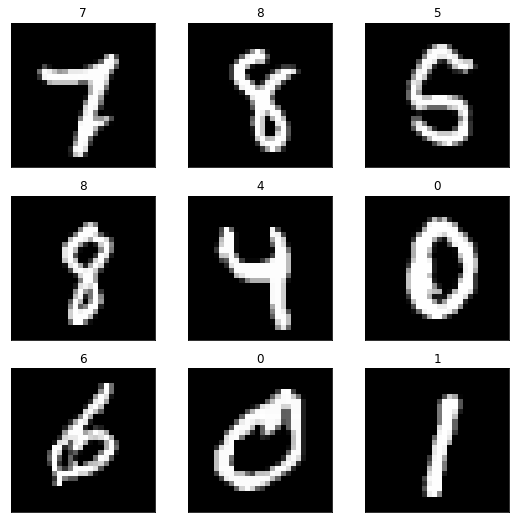

In [19]:
plots(X_train[:9], y_train[:9])

For this classification problem, we will one-hot-encode the labels.

In [20]:
y_train[:3]

array([7, 8, 5], dtype=int64)

In [21]:
yoh_train, yoh_valid = [to_categorical(y) for y in [y_train, y_valid]]

In [22]:
yoh_train[:3]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]], dtype=float32)

## Train a neural network with flattened images

In [23]:
def flatten(x): return x.reshape(x.shape[0], -1)

In [24]:
X_train_flat = flatten(X_train)
X_valid_flat = flatten(X_valid)
X_test_flat = flatten(X_test)

In [25]:
X_train_flat.shape

(31500, 784)

In [26]:
nn = Sequential([
    Dense(256, input_shape=(784,), activation='relu'),
    Dense(10, activation='softmax'),
])

In [27]:
def softmax(x):
    np.exp(x) / np.sum(np.exp(x))

In [28]:
z = [2, 6, 3, 5]

In [29]:
np.exp(z)

array([   7.3890561 ,  403.42879349,   20.08553692,  148.4131591 ])

In [30]:
out = np.exp(z) / np.sum(np.exp(z))
out, out.sum()

(array([ 0.01275478,  0.69638749,  0.03467109,  0.25618664]), 1.0)

Next we need to judge how good our predictions is. For classification we use the categorical crossentropy:

$L = - \sum_c y_t^c \log(y_p^c)$

$c$ is the class, so one of our ten numbers.

In [31]:
nn.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [32]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [33]:
nn.fit(X_train_flat, yoh_train, batch_size=512, epochs=10, validation_data=(X_valid_flat, yoh_valid))

Train on 31500 samples, validate on 10500 samples
Epoch 1/10
31500/31500 [==============================] - 1s 41us/step - loss: 0.6604 - acc: 0.8264 - val_loss: 0.3200 - val_acc: 0.9090
Epoch 2/10
31500/31500 [==============================] - 1s 35us/step - loss: 0.2727 - acc: 0.9254 - val_loss: 0.2493 - val_acc: 0.9285
Epoch 3/10
31500/31500 [==============================] - 1s 35us/step - loss: 0.2159 - acc: 0.9397 - val_loss: 0.2113 - val_acc: 0.9402
Epoch 4/10
31500/31500 [==============================] - 1s 41us/step - loss: 0.1799 - acc: 0.9497 - val_loss: 0.1811 - val_acc: 0.9486
Epoch 5/10
31500/31500 [==============================] - 1s 34us/step - loss: 0.1528 - acc: 0.9576 - val_loss: 0.1658 - val_acc: 0.9542
Epoch 6/10
31500/31500 [==============================] - 1s 38us/step - loss: 0.1312 - acc: 0.9637 - val_loss: 0.1445 - val_acc: 0.9616
Epoch 7/10
31500/31500 [==============================] - 1s 44us/step - loss: 0.1130 - acc: 0.9696 - val_loss: 0.1334 - val_acc

## CNN

To take advantage of the spatial information in images we can use convolutions rather than fully connected layers.

http://setosa.io/ev/image-kernels/

In [34]:
cnn = Sequential([
    Conv2D(32, kernel_size=5, strides=2, activation='relu', padding='same', 
           input_shape=(28, 28, 1)),
    Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2D(128, kernel_size=3, strides=2, activation='relu', padding='same'),
    Flatten(),
    Dense(10, activation='softmax'),
])

In [35]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20490     
Total params: 113,674
Trainable params: 113,674
Non-trainable params: 0
_________________________________________________________________


In [36]:
cnn.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [37]:
cnn.fit(X_train, yoh_train, batch_size=512, epochs=10, validation_data=(X_valid, yoh_valid))

Train on 31500 samples, validate on 10500 samples
Epoch 1/10
31500/31500 [==============================] - 14s 456us/step - loss: 0.8495 - acc: 0.7582 - val_loss: 0.3077 - val_acc: 0.9124
Epoch 2/10
31500/31500 [==============================] - 14s 453us/step - loss: 0.2453 - acc: 0.9282 - val_loss: 0.1988 - val_acc: 0.9434
Epoch 3/10
31500/31500 [==============================] - 15s 465us/step - loss: 0.1611 - acc: 0.9523 - val_loss: 0.1318 - val_acc: 0.9625
Epoch 4/10
31500/31500 [==============================] - 14s 450us/step - loss: 0.1137 - acc: 0.9663 - val_loss: 0.1039 - val_acc: 0.9692
Epoch 5/10
31500/31500 [==============================] - 15s 471us/step - loss: 0.0875 - acc: 0.9740 - val_loss: 0.0984 - val_acc: 0.9694
Epoch 6/10
31500/31500 [==============================] - 15s 461us/step - loss: 0.0749 - acc: 0.9779 - val_loss: 0.0859 - val_acc: 0.9730
Epoch 7/10
31500/31500 [==============================] - 15s 483us/step - loss: 0.0614 - acc: 0.9817 - val_loss: 0.

### Submit to kaggle

In [38]:
preds = cnn.predict(X_test)
pred_idxs = np.argmax(preds, axis=1)

In [39]:
df =  pd.DataFrame({'ImageId': range(1, len(preds)+1), 'Label': pred_idxs})

In [40]:
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [41]:
df.to_csv(DATADIR + 'cnn.csv', index=False)

## Your turn

In this notebook, I only outlined a very basic approach. Hopefully, you are fmiliar enough with machine learning in Python that you can use the internet and look for ways to improve your score. MNIST is a exceptionally well-studied dataset, so you will find many, many examples out there.

- One thing to look at is which images the CNN gets wrong. Does it make sense?